# 4 - VGG

In this notebook we will be implementing one of the [VGG](https://arxiv.org/abs/1409.1556) model variants. VGG is a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), which it won in 2014.

VGG is not a single model, but a family of models that are all similar but have different *configurations*. Each configuration specifies the number of layers and the size of each layer. The configurations are listed in table 1 of the [VGG paper](https://arxiv.org/pdf/1409.1556.pdf) and denoted by a letter, although recently they are just referred to as the number of layers with weights in the model, e.g. configuration "A" has 11 layers with weights so is known as VGG11.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg-table.png?raw=1)

Below is the architecture of configuration "D", also known as VGG16, for a 224x224 color image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg.png?raw=1)

The other commonly used VGG variants are VGG11, VGG13 and VGG19, which correspond to configurations "A", "B", and "E". Configurations "A-LRN" and "C" - which is the same as "D" but with smaller filter sizes in some convolutional layers - are rarely used.

As in the previous notebook, we will use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset and the learning rate finder introduced [here](https://arxiv.org/abs/1506.01186). However we will be making use of *pre-trained* models. 

Usually we will initialize our weights randomly - following some weight initialization scheme - and then train our model. Using a pre-trained model means some - potentially all - of our model's weights are not initialized randomly, but instead taken from a copy of our model that has already been trained on some task. The task the model has been pre-trained on does not necessarily have to match the "downstream task" - the task we want to use the pre-trained model on. For example, a model that has been trained to classify images can then be used to detect objects within an image.

The theory is that these pre-trained models have already learned high level features within images that will be useful for our task. This means we don't have to learn them from scratch when using the pre-trained model for our task, causing our model to converge earlier. We can also think of the pre-trained model as being a very good set of weights to initialize our model from, and using pre-trained models usually leads to a performance improvement compared to initializing our weights randomly. 

The act of using a pre-trained model is generally known as *transfer learning*, as we are learning to transfer knowledge from one task to another. It is also referred to as *fine-tuning*, as we fine-tune our parameters trained on one task to the new, downstream task. The terms *transfer learning* and *fine-tuning* are used interchangably in machine learning. 

We are also going to look into a technique called [discriminative fine-tuning](https://arxiv.org/abs/1801.06146), initially introduced to improve transfer learning for text classification but has been used for computer vision tasks too. 

### Data Processing

As always, we'll import the modules we need. No new imports yet.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

We'll also set the random seeds.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Defining the Model

Usually the next thing we'd do is load our data, however this is quite different when using a pre-trained model, so we'll first introduce the VGG architecture and then show how to load a pre-trained VGG model.

Below is the general VGG model. This is the part of VGG that is common for all VGG configurations. The only part that depends the configuration is the `features`, which we will pass as an argument when we construct the VGG model.

The only new feature introduced here in the `AdaptiveAvgPool2d`. As well as the standard `AvgPool` and `MaxPool` layers, PyTorch has "adaptive" versions of those layers. In adaptive pooling layers we specify the desired output size of the pooling layer instead of the size of the filter used by the pooling layer. Here, we want an output size of 7x7. We know that all VGG configurations end with a convolutional layer that has 512 filters, thus if our `features` layer for each configuration always has a size of 7x7 we do not have to change the `classifier` for each VGG configuration. The advantage of using adaptive layers is that it allows us to apply our model to images of different sizes - down to a minimum size, which is 32x32 in VGG models.

**Note:** even though VGG net can handle images as small as 32x32 it is designed to give optimal performance for larger images. We handle this later on in this tutorial.

How do the adaptive pooling layers calculate the size of their filters? For each dimension, i.e. height and width, we calculate:

```
filter_size = (input_size + desired_size - 1) // desired_size
```

`//` means we round down to the nearest integer. So, if we wanted to filter a 32x32 image to 7x7 we would have a 6x6 filter. When the filter is applied to the image it will need to overlap at some points, i.e. some pixels will be covered by the filter twice. To calculate the positions of the filter we split the 32x32 image into `desired_size` evenly spaced points. 

This can be calculated with `np.linspace(0, input_size - desired_size, desired_size)` which for our example gives us: `[0, 4.16666667, 8.33333333, 12.5, 16.66666667, 20.83333333, 25]`. We then round each of these points down to the nearest integer as we cannot have a filter cover a fraction of a pixel, which gives us: `[0, 4, 8, 12, 16, 20, 25]`. Thus, the 6x6 filter covers pixels: 0-5, 4-10, 8-14, 12-18, 16-22, 20-26 and 25-31 in each dimension.

Let's define the VGG base architecture. 

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        
        self.features = features
        
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

Next up is calculating the `features` for each VGG configuration.

Typically the VGG configurations are defined as lists. Each item in the list is either 'M', which denotes a max pooling layer, or an integer, which denotes a convolutional layer with that many filters.

Below are the configurations for VGG11, VGG13, VGG16 and VGG19. Otherwise known as configurations "A", "B", "D" and "E", respectively.

In [ ]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']

We can now define a function which takes in a configuration list and returns a `nn.Sequential` with the respective layers.

`get_vgg_layers` iterates over the configuration list and appends each layer to `layers`, then it converts them to a `nn.Sequential` as it returns. 

We can see that we always use the same size filter (2x2) and stride (2) in all of our max pool layers. As mentioned in previous tutorials, the default stride for pooling layers is equal to the kernel size.

For the convolutional layers we always the same filter size (3x3) and padding (1). As a reminder, padding adds `padding` pixels with values of zero around each side of the image in each channel before the filter is applied. Each convolutional layer is followed by a ReLU non-linearity. We then set the `in_channels` to be equal to the number of filters in the convolutional layer so the next convolutional layer has the correct `in_channels`.

Another new layer introduced here is [batch normalization](https://arxiv.org/abs/1502.03167) (BN) defined with `BatchNorm2d` and only used if `batch_norm = True`. As mentioned in previous tutorials, normalization is when we try to ensure that some data has a mean of zero and a standard deviation (std) of one as this improves learning - both stability and convergence speed - in machine learning models. Previously we have normalized our input data using PyTorch transforms and tried to ensure our data remains as normalized as possible by using weight initialization schemes - such as Glorot or Kaiming. However, as our model begins to train and the parameters change then the mean and std output by each layer will also change. A change in mean and std of the output of one layer will cause a change in mean and std for all following layers. Our model has no way to correct these changes in means and stds once training has begun.

BN is a layer with learnable parameters - two per filter - denoted $\gamma$ and $\beta$. The layer normalizes, scales and then shifts across the channel dimension of the input. The output of a BN layer is calculated by:

$$
\begin{align}
\mu_\mathcal{B} &= \frac{1}{m}\sum^m_{i=1} x_i\\
\sigma^2_\mathcal{B} &= \frac{1}{m}\sum^m_{i=1}(x_i-\mu_\mathcal{B})^2\\
\hat{x}_i &= \frac{x_i - \mu_\mathcal{B}}{\sqrt{\sigma^2_\mathcal{B} + \epsilon}}\\
y_i &= \gamma \hat{x}_i + \beta = \text{BN}_{\gamma,\beta}(x_i) 
\end{align}
$$

The batch $\mathcal{B}$ has $m$ examples, $x_i,\dots,x_m$. We first calculate the mean and variance across each channel dimension of the batch, $\mu_\mathcal{B}$ and $\sigma^2_\mathcal{B}$. Then normalize the batch by subtracting the channel means and dividing by the channel stds (the square root of the variance plus a small epsilon term to avoid division by zero) across each channel. We then scale and shift each channel of this normalized batch of inputs, $\hat{x}_i$ using $\gamma$ and $\beta$.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/batch-norm.png?raw=1)

Why do we scale and shift? Why not leave the outputs with a mean of zero and a std of one? Perhaps there is a better mean and std for our task instead of zero and one. If this is the case then our model can learn this whilst training as $\gamma$ and $\beta$ are learnable parameters. However, to bias our model to start off with the idea that a mean of zero and a std of one is a good idea by default $\gamma$ and $\beta$ are initialized to one and zero.

There are a few things to consider with batch normalization during inference time (validation or testing). The first is that we don't want to calculate the mean and variance of our data to normalize it during inference. This is because an image in the validation or test set might be drastically different to an image in the training set, and we do not want to remove that information via normalization. The second is what to do with a batch size of one, common when deploying models. Calculating the mean and variance across a single example (a batch size of one) doesn't make sense. 

Luckily, there is a solution to both these problems. Instead of using the actual mean and variance of a batch, we use an exponentially weighted moving average which we update every batch. Then, when using inference (with any batch size, including one) we use the saved weighted average of the means and variances. 

[This](https://www.youtube.com/watch?v=HR0lt1hlR6U&t=5900) video has a good explanation of batch normalization and other types of normalization layers. For another explanation on why batch normalization helps, check out [this](https://arxiv.org/abs/1805.11604) paper.

One last thing to mention on batch normalization is that, in theory, it should be used **after** the activation function. Why would you normalize the output of a layer only to just ruin the normalization effect with an activation function? However, in the original VGG architecture they use batch normalization before the activation function, so we do too. 

In [ ]:
def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

Now, let's get the `features` for the VGG11 architecture, with batch normalization.

The original VGG paper did not use batch normalization, but it is now common to use it in VGG models.

In [ ]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

We can print them out and ensure they are the same as the "A" configuration of the VGG configuration table.

In [7]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

We can then pass these `features` to our base VGG module to get our VGG11 model.

In [8]:
OUTPUT_DIM = 10

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Pre-trained Models

In this notebook we aren't actually going to use a VGG model with parameters that have been randomly initialized VGG model. We are going to be using a VGG model with *pre-trained* parameters. Using a pre-trained model involves initializing our model with parameters that have already been trained for a certain task - usually not the exact same task we are trying to do ourselves.

Torchvision has ways to easily download a pre-trained model. We simply import the `torchvision.models` package, specify which model we want to use and then pass the argument `pretrained = True`. We can see a list of all available pre-trained models provided by torchvision [here](https://pytorch.org/docs/stable/torchvision/models.html). 

Let's import a pre-trained VGG11 with batch normalization. The first time this code is run the pre-trained parameters will be downloaded and are around 140MB for VGG11 with batch normalization.

In [9]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained = True)

print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

As we can see, the pre-trained model loaded is exactly the same as the one we have defined with one exception - the output of the final linear layer. 

All of torchvision's pre-trained models are trained as image classification models on the [ImageNet](http://www.image-net.org/challenges/LSVRC/) dataset. A dataset of 224x224 color images with 1000 classes, therefore the final layer will have a 1000 dimensional output.

We can get the last layer specifically by indexing into the `classifier` layer of the pre-trained model.

In [10]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

As our dataset, CIFAR10, only has 10 classes then we want the last layer to have a 10 dimensional output. 

We'll define a new final linear layer which has to have an input size equal to that of the layer we are replacing - as it's input will be the 4096 dimensional output from the previous linear layer in the classifier. The output of this linear layer will be 10 dimensions - as our dataset has 10 classes.

In [ ]:
IN_FEATURES = pretrained_model.classifier[-1].in_features 

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

We can directly overwrite the previous linear layer with our new linear layer. 

Note that our `final_fc` will be initialized randomly. It is the only part of our model with its parameters not pre-trained.

In [ ]:
pretrained_model.classifier[-1] = final_fc

We can then print out the `classifier` of our model to ensure the final linear layer now has an output dimension of 10.

In [13]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


We could go ahead and use the `pretrained_model` module from here on out, however it only returns the final output layer and not the intermediate representation as our `model` does. We can see that in the model's definition [here](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py#L47). 

We can load the parameters of the `pretrained_model` into our `model` by loading the parameters (`state_dict`) from the `pretrained_model` into our `model` in the same way we loaded the "best" saved parameters in the previous notebooks - by using `load_state_dict`. However, this time we load directly from the `pretrained_model` instead of using `torch.load` on the path of the saved model parameters. 

This is only possible as our `model` has the exact same layers (order and shape) as the `pretrained_model` with the final linear layer replaced with our 10 dimensional output linear layer.

In [14]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

This model has considerably more parameters than the previous model, AlexNet - 128M compared to 23M.

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 128,812,810 trainable parameters


Instead of training all of the parameters we have loaded from a pre-trained model, we could instead only learn some of them and leave some "frozen" at their pre-trained values. As our model will then have less trainable parameters it will usually train faster and we can usually fit it on smaller GPUs. 

We aren't going to freeze any parameters in this notebook, but if we wanted to freeze the `features` layer then we could do that with:

```python
for parameter in model.features.parameters():
    parameter.requires_grad = False
```

We could also freeze the `classifier` layer, however we always want to train the last layer as this is what we have initialized randomly and needs to be trained. Freezing all but the last layer in the `classifier` can be done with:

```python
for parameter in model.classifier[:-1].parameters():
    parameter.requires_grad = False
```

### Data Processing

There's a few things we need to consider in regards to data processing when using pre-trained models.

As mentioned in the torchvision models [page](https://pytorch.org/docs/stable/torchvision/models.html):

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Thus, we need to resize our 32x32 images to 224x224 and also normalize them with the given means and stds instead of calculating them from the CIFAR10 dataset.

Even though the VGG models can handle images as small as 32x32 and convolutional layers are translation invariant, our images still need to be resized as the pre-trained `classifier` layer is expecting certain features to appear in certain places within the flattened 512x7x7 output of the `features` layer after the adaptive average pooling. Using a different image size than was used to pre-train the model causes features sent to the `classifier` to be in different places than expected, and thus leads to poor performance when using the pre-trained model.

We need to use the same means and stds to make the colors of the images fed to the model with the pre-trained parameters be the same as they were to train the pre-trained model. Let's say the original dataset had lots of dark green images and the mean for the green channel was be relatively low, say 0.2, and the dataset we are going to use had lots of light green images with the mean for the green channel being around 0.8. The pre-trained model was trained with dark green pixels normalized to zero (subtracting the mean). If we incorrectly used the means and stds from our dataset we want to apply our model on, then light green pixels will be normalized to zero, thus our pre-trained model will think a given light green image is actually a dark green image. This will confuse our model and lead to poor performance.

We handle the resizing with the `Resize` transform, passing in the desired size. As the images are larger we can also get away with slightly higher rotations and crops within the `RandomRotation` and `RandomCrop` transforms. We pass the pre-trained mean and stds the same way we would pass our calculated means and transforms.

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

The rest of this notebook will be similar to previous notebooks.

We'll load the data with our defined transforms...

In [17]:
ROOT = '.data'

train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


...then create the validation split...

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

...and ensure the validation data uses the test transforms.

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Again, we'll print out the number of examples in each split to ensure they are correct.

In [20]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


We'll also plot out a few images to ensure the transformations look sensible - making sure to re-normalize our data so we can view it with the correct colors.

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

As we can see, the larger images mean we can get away with larger amounts of rotation and cropping with the images still looking reasonable.

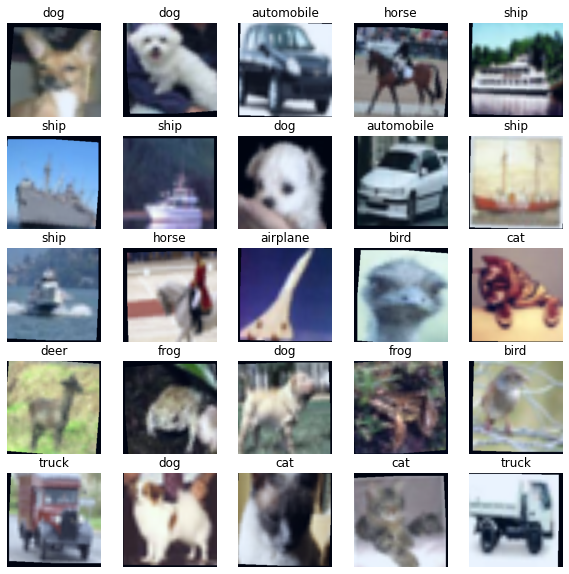

In [22]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

As the model is ~5x the size of the AlexNet model from the previous notebook we use a smaller batch size so it can fit on reasonably sized GPUs. This should be increased if we have access to GPUs with more memory in order to speed up training.

In [ ]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

### Training the Model

We'll use the learning rate finder as used in previous notebooks. Generally when using a pre-trained model the learning rate used will be considerably lower.

First, we'll set up the optimizer with the initial learning rate that is much lower than we expect to use. Then we define the `device` to place our model on our GPU, if we have one. Next we define the `criterion` (loss function) and place the model and criterion on our device.

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We then define the learning rate finder class. See the previous notebook for details on how this works.

In [ ]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch # + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

Next, we run the learning rate finder...

In [26]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


...and plot the loss achieved per batch for each learning rate value tested.

In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

As we can see, the loss remains almost constant until around $1x10^{-4}$, it then decreases rapidly before diverging. 

A good learning rate from this is the middle of the steep decline which is around $5x10^{-4}$.

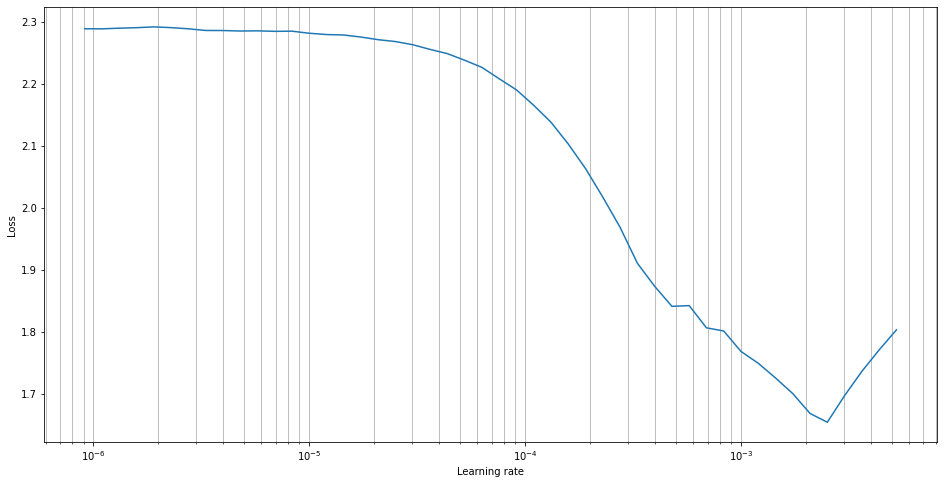

In [28]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

We can now create an optimizer with our found learning rate and using discriminative fine-tuning. 

The concept behind descriminative fine-tuning is that we use different learning rates for different layers in our models. The hypothesis is that early layers in a neural network learn to extract more general features, whilst later layers learn to extract more task specific features. If this is true, then the general features extracted by the early layers should be useful for any task, and we should change the pre-trained weights of them by a very small amount - if at all. 

**Note:** discriminative fine-tuning should only be used when performing transfer learning from a pre-trained model. It is typically not necessary to use it when training a model from randomly initialized weights. 

PyTorch allows us to set different learning rate values per parameter in our model. This is done by passing a list of dictionaries to the optimizer. Each dictionary should state the parameters (`'params'`) and also any other arguments that will override those given directly to the optimizer. 

Here, instead of using a different learning rate for every single layer, we have split the parameters into two "groups": `features`, which contains all of the convolutional layers; and `classifier`, which contains all of the linear layers. `classifier` will be using the `FOUND_LR` given directly to the optimizer and `features` will be using `FOUND_LR / 10`, as specified in the first dictionary. Thus, our convolutional layers have a learning rate 10x less than the linear layers.

In [ ]:
FOUND_LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

Now all of the set-up is done, the rest of the notebook is pretty standard from here on out.

We create a function to calculate accuracy...

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...create a function that implements a training loop...

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...create a function that performs an evaluation loop...

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...and a helper function to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

As our images have been resized to be significantly larger and our model has significantly more parameters training takes considerably longer. However, when performing transfer learning we usually train for significantly less epochs and are still able to achieve much higher accuracy than before.

We get ~94% validation accuracy in only five epochs.

In [34]:
EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 7m 43s
	Train Loss: 0.444 | Train Acc: 84.68%
	 Val. Loss: 0.240 |  Val. Acc: 91.68%
Epoch: 02 | Epoch Time: 7m 42s
	Train Loss: 0.211 | Train Acc: 92.87%
	 Val. Loss: 0.235 |  Val. Acc: 91.95%
Epoch: 03 | Epoch Time: 7m 41s
	Train Loss: 0.143 | Train Acc: 95.20%
	 Val. Loss: 0.219 |  Val. Acc: 93.40%
Epoch: 04 | Epoch Time: 7m 41s
	Train Loss: 0.108 | Train Acc: 96.46%
	 Val. Loss: 0.230 |  Val. Acc: 93.65%
Epoch: 05 | Epoch Time: 7m 41s
	Train Loss: 0.082 | Train Acc: 97.34%
	 Val. Loss: 0.230 |  Val. Acc: 94.18%


Our test accuracy is a little lower at ~92%, but is still higher than the ~75% achieved by the AlexNet model in the previous tutorial notebook.

In [35]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.242 | Test Acc: 92.30%


### Examining the Model

We'll do the same examinations on the model as we have done on the previous notebooks.

First, we'll get the predictions for each of the examples in the test set...

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)

...then get the predicted labels for each image...

In [ ]:
pred_labels = torch.argmax(probs, 1)

...and then use these predictions to create a confusion matrix.

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

Similar to the previous notebook, the most commonly confused classes are dogs and cats.

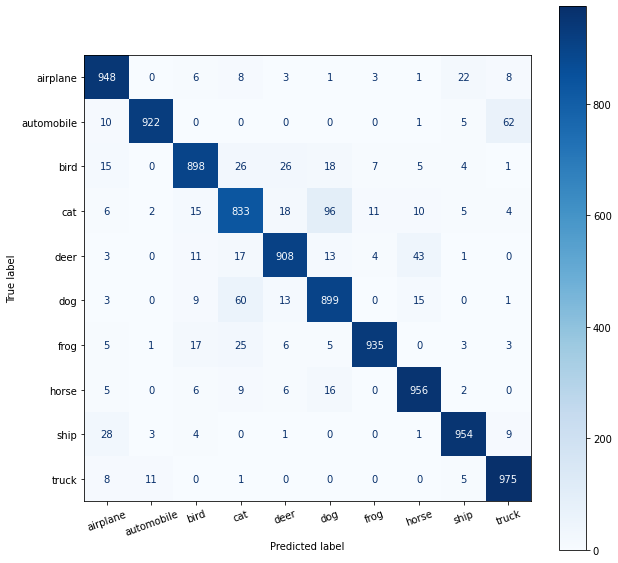

In [40]:
plot_confusion_matrix(labels, pred_labels, classes)

We'll then find out which predictions were incorrect and then sort these incorrect predictions by how confident our model was.

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot these most confident incorrect predictions.

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.5)

Again, the frog that was incorrectly labelled as a cat is there with a lot of automobile/truck confusion.

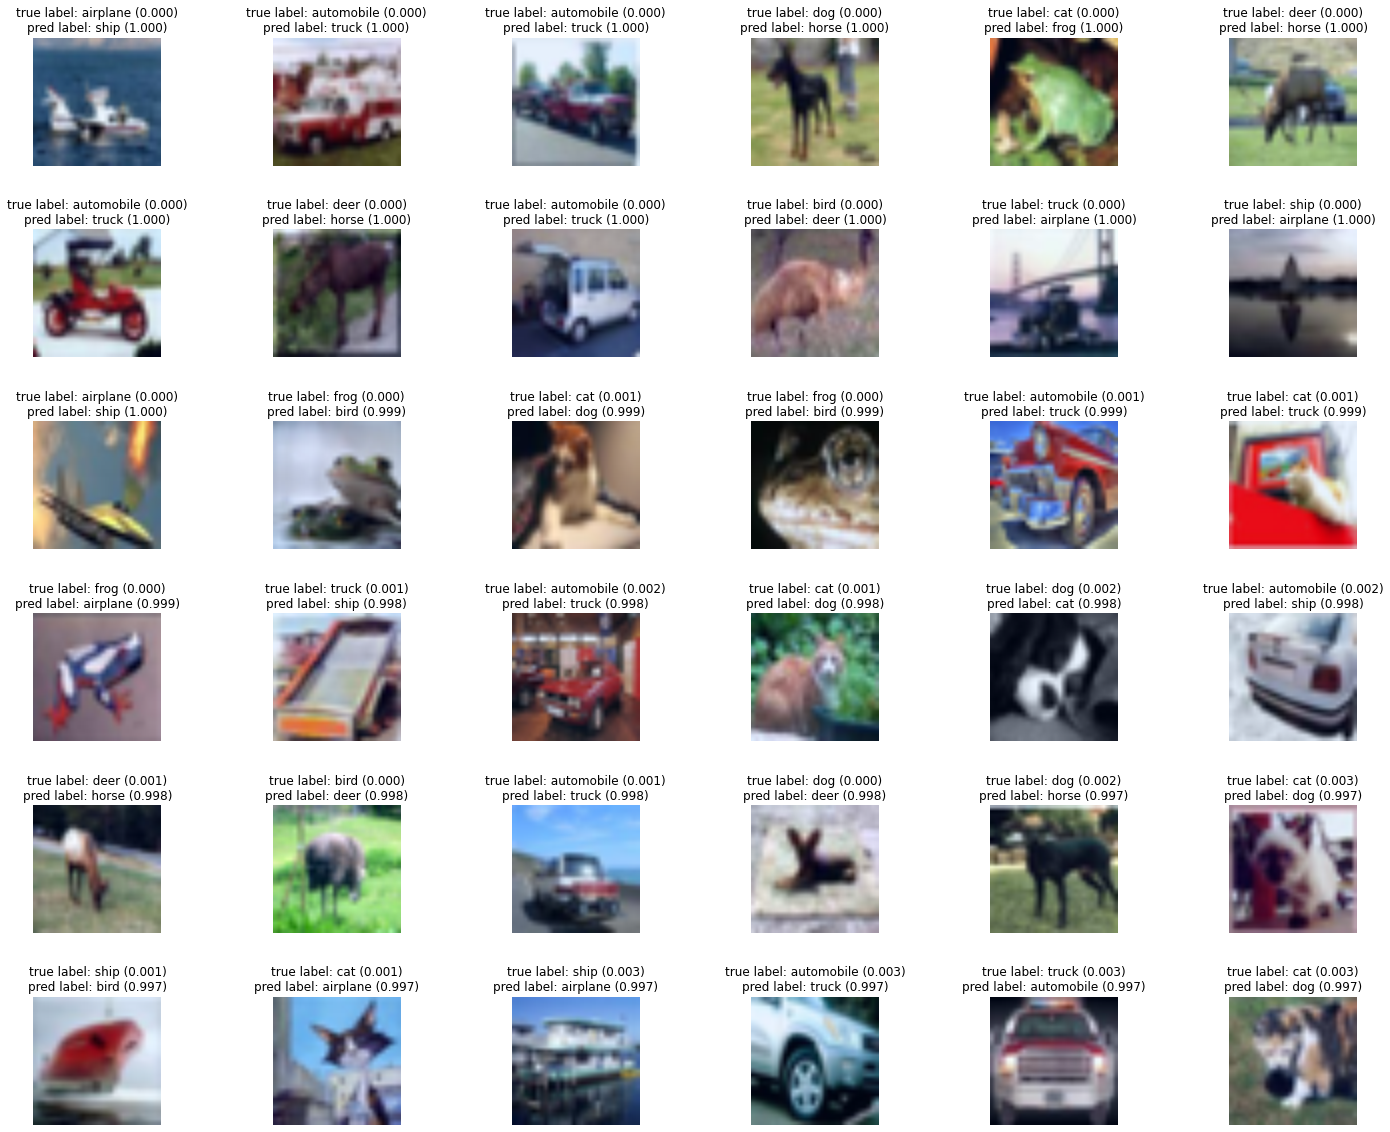

In [44]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next up is plotting the representations of the model with PCA and then t-SNE.

We are only going to plot the output representations and not the intermediate ones here. This is because the output dimensions are ten dimensional but the intermediate representations have over 25,000 dimensions and storing these in memory takes a considerably amount of RAM.

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

First, we gets the output representations...

In [ ]:
outputs, labels = get_representations(model, train_iterator)

Next, we define a function to perform PCA on the representations and plot the PCA output.

In [ ]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

We can then plot the PCA representations.

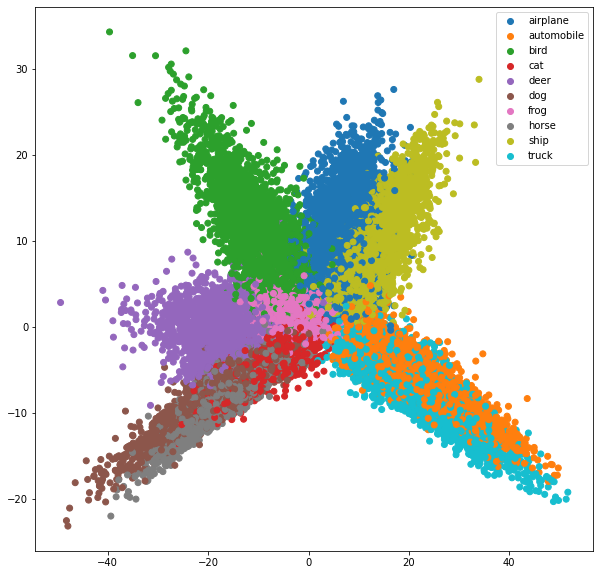

In [49]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

Next up is calculating the t-SNE representations.

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

As mentioned in previous notebooks t-SNE takes a lot longer to compute compared to PCA, thus we only use a sample of the representations to calculate the t-SNE embeddings.

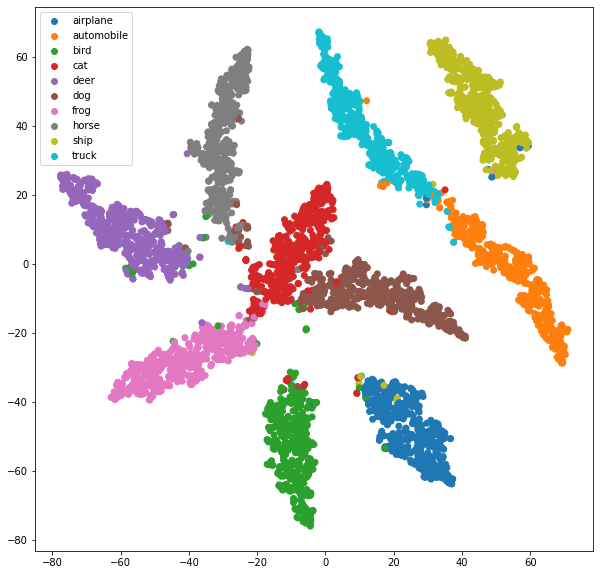

In [51]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images = N_IMAGES)

We'll then get the filters learned by our model and plot some images with the filters applied to them.

In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = 0.3)

We can see that the filters learned by the model do different types of edge detection, color inversion and blurring.

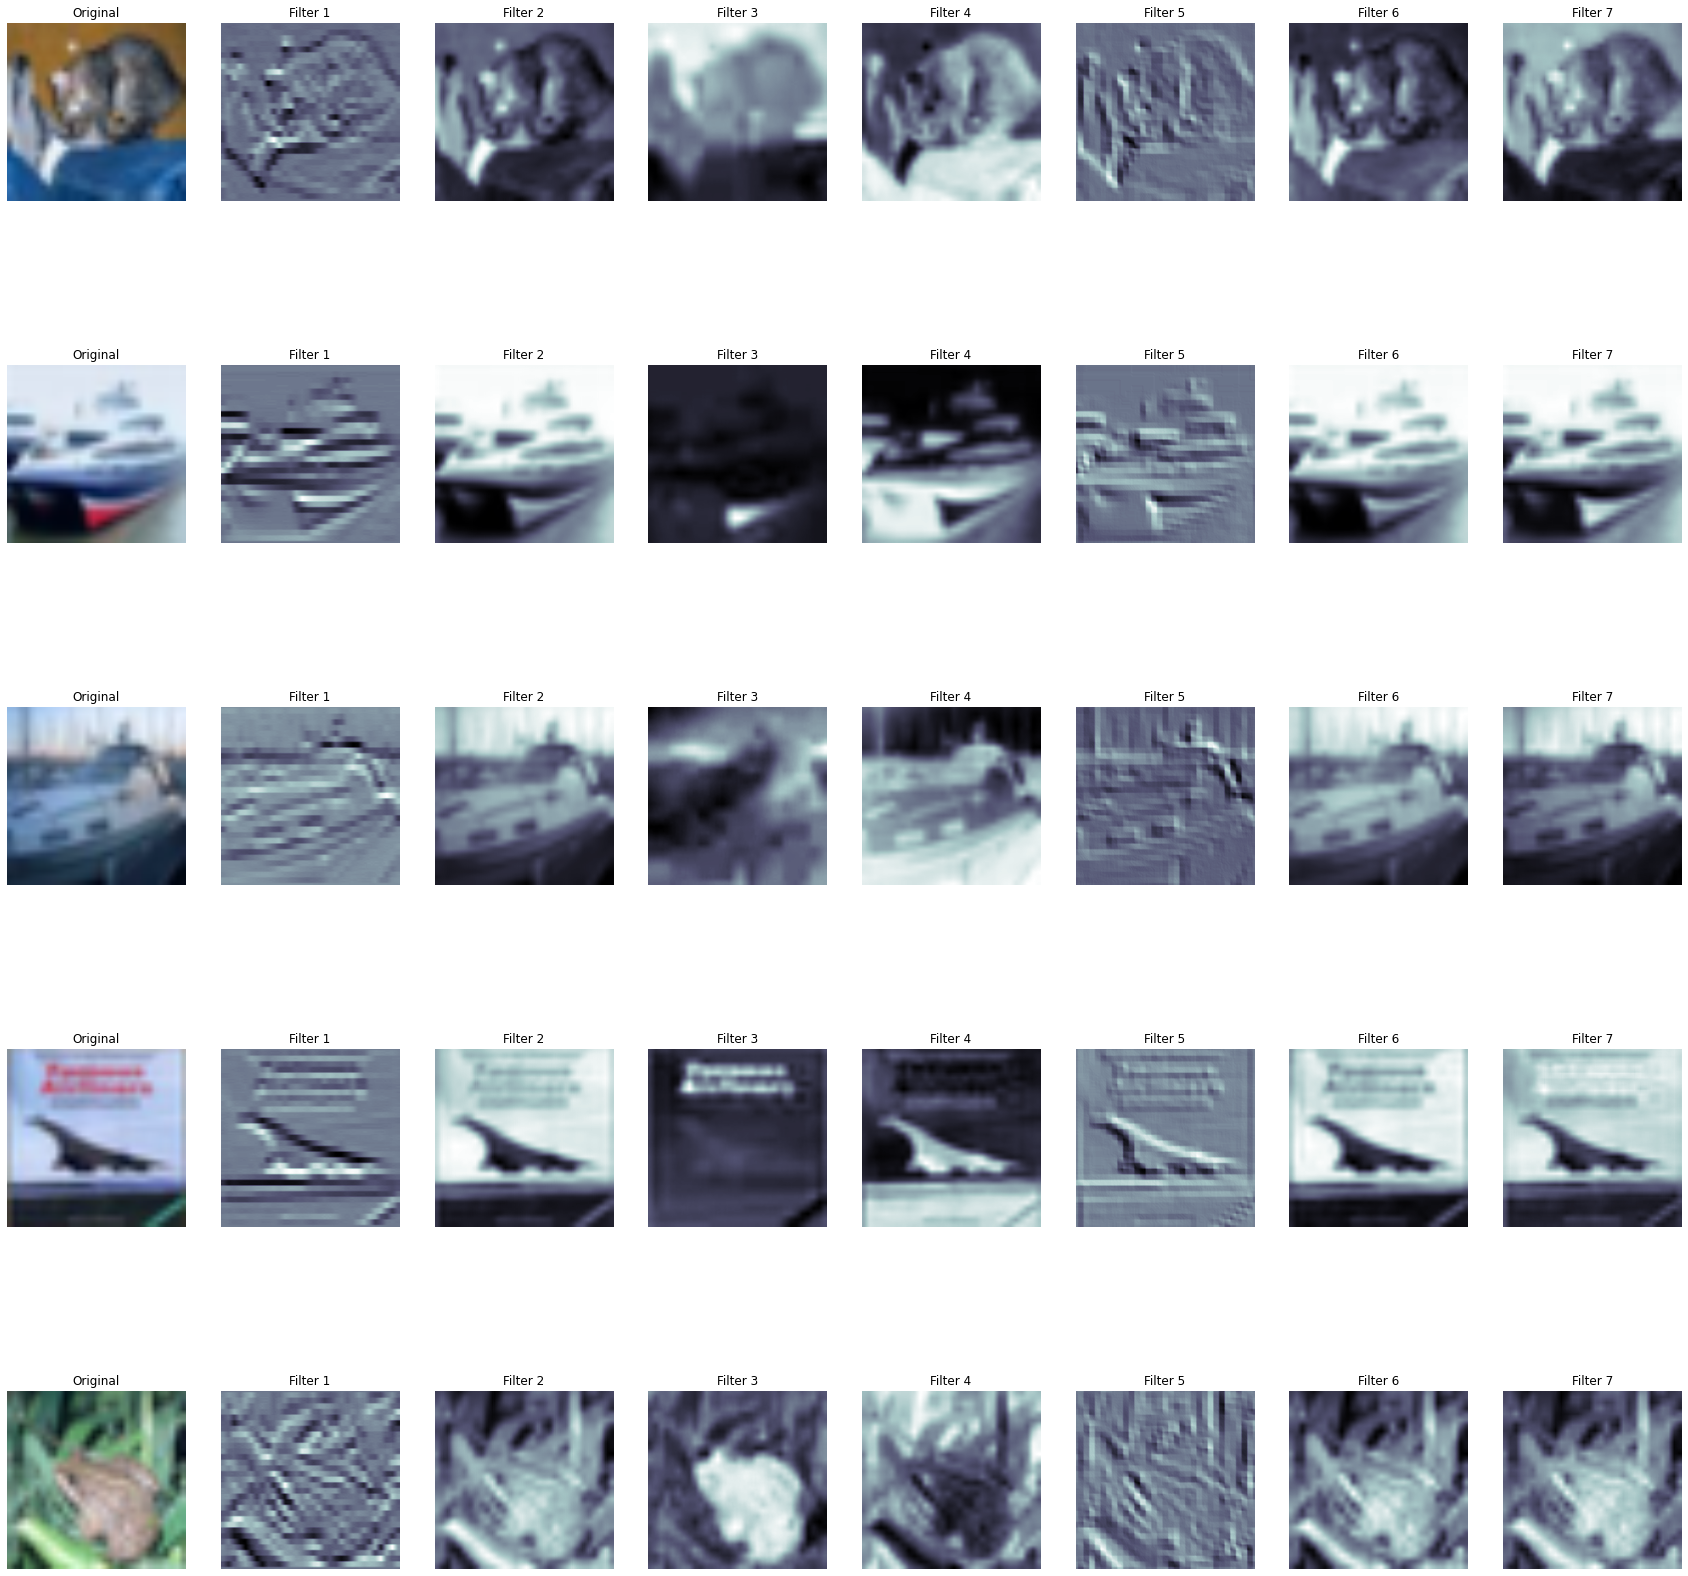

In [53]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

We can also plot out the actual filter weights learned by the model.

In [ ]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

Even though these aren't as interpretable as the pre-trained AlexNet filters shown in the previous notebook, they are more interesting than the AlexNet filters learned from scratch. 

Interestingly there are multiple filters that are completely black, implying they all have filters weights that are basically zero.

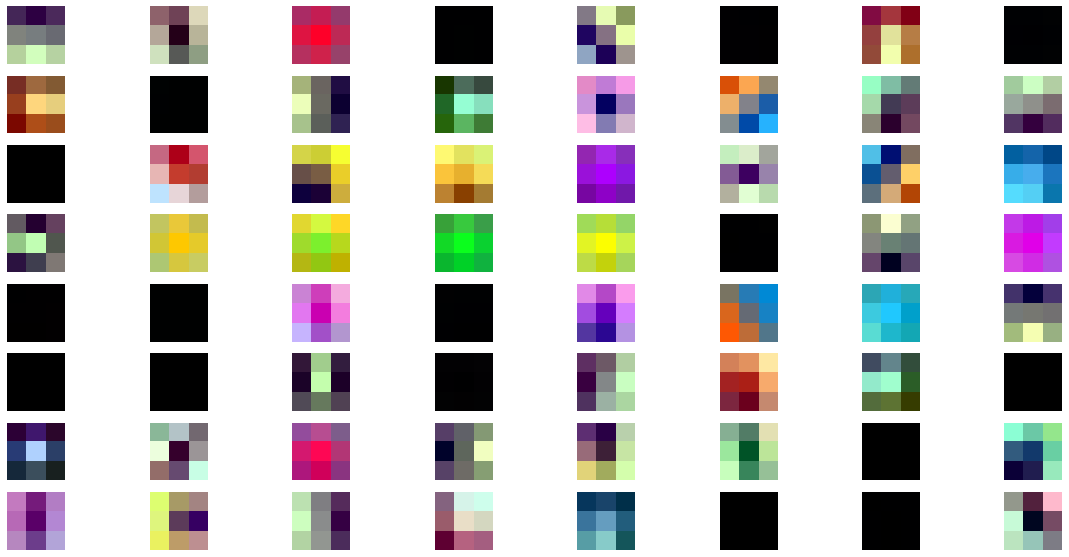

In [55]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- defining a CNN (VGG)
- adaptive pooling
- batch normalization
- loading a pre-trained model
- loading pre-trained model parameters into a defined model
- how to freeze weights of our model
- how to use discriminative fine-tuning
- fine-tuning a pre-trained model to achieve >94% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- viewing the learned weights of our model

In the next notebook we'll implement yet another popular CNN architecture, ResNet, and learn about how to pre-trained models ourselves using self-supervised learning.